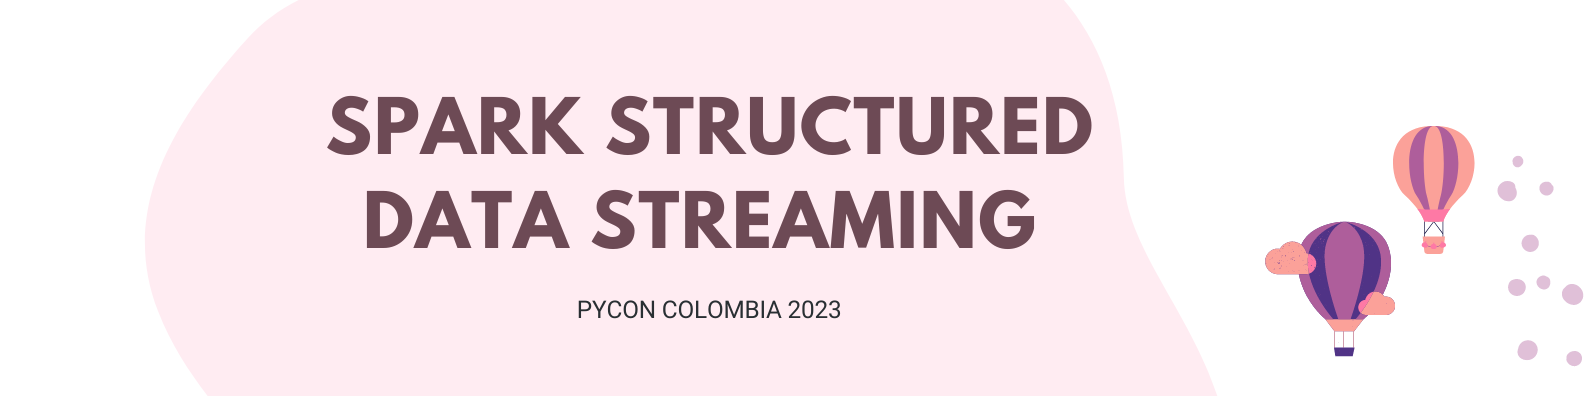

# **1. Crear Reddit App**

Ingresa a https://www.reddit.com/prefs/apps y crea tu App para tener acceso a la API.

![pictureAPI](https://drive.google.com/uc?export=view&id=1DobGduiERNAvum72JTmWwpBSYmfZ8k6Y)

Luego llena los campos obligatorios, establece un nombre y descripción.
![picture](https://drive.google.com/uc?export=view&id=1dmzK6chKQPFTu3L7D2OUnx8MljBWVJ3j)

Finalmente, guarda los siguientes datos que se usarán para autenticarnos (CLIENT ID & CLIENT SECRET)

![picture](https://drive.google.com/uc?export=view&id=1iN1vn31EltYaFK1CH21lXhU71Y1Eek2g)

# **2. Instalación de librerías**
***Praw***: Python Reddit API Wrapper, es un paquete de Python que permite un acceso simple a la API de Reddit. https://praw.readthedocs.io/en/stable/


In [ ]:
!pip install pyspark praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 18.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=c021f8b7d692051f96ba43507c729260a1cb9bd8ce664886f64f325fa692a2e3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import praw

# **3. Creación de la sesión de Spark**

In [ ]:
spark = SparkSession.builder \
    .appName("Reddit API Streaming") \
    .getOrCreate()


# **4. Conexión a la API de Reddit**
* ***Username***: Tu usuario de acceso a Reddit 
* ***Password***: Guarda la contraseña en un archivo de texto y cárgalo en el notebook.
* ***ClientId***: El Id guardo del paso 1.
* ***ClientSecret***: El Id guardo del paso 1.

In [ ]:
USERNAME = 'valearizag'
with open('pass.txt','r') as f:
  PASSWORD = f.read()

In [ ]:
reddit = praw.Reddit(
         client_id='e6HcBgtzmhOZ1FtF8cG1ig',
        client_secret='bVqjibgsXl_ejhaIj_MSBYp8A0cUQQ',
        user_agent='PrawTut',
        username=USERNAME,
        password=PASSWORD,
        check_for_async=False
    )

# **5. Extracción de datos de Reddit API**

In [ ]:
subreddit = "python"
limit = 100

In [ ]:
def get_data():
    subreddit_data = reddit.subreddit(subreddit).new(limit=limit)
    data = [(post.title, post.author.name, post.id) for post in subreddit_data]
    return data

In [ ]:
get_data()

[('PGP signatures on PyPI: worse than useless', 'ubernostrum', '13ocv2p'),
 ('2D table top game', 'Beaver_Boi12', '13oc7si'),
 ('is it true or false', 'lustykindagay', '13ob4yp'),
 ('Monday Daily Thread: Project ideas!', 'Im__Joseph', '13oakho'),
 ('A simple CLI for asking questions on your own PDFs using GPT-3.5-Turbo',
  '1Blademaster',
  '13o7ssn'),
 ('numpysane: more reasonable core functions for numpy', 'dima55', '13o7nnr'),
 ("What's your Python story?", 'Fine-Divide-5057', '13o6r6r'),
 ('First Pet-Project', 'dan_flyjeray', '13o5hex'),
 ('PEP 658', 'help-me-grow', '13o4x3z'),
 ('WhisperFlow: Unleash the Magic of Infinite Storage on YouTube!',
  'JizosKasa',
  '13o4ith'),
 ('Python syntax tutorial', 'Exotic-Foundation119', '13o2qna'),
 ('Using a Golang package in Python using Gopy',
  'PrathameshSonpatki',
  '13o2ch6'),
 ('How long to learn Python until I can automate a data entry job?',
  'captainofthememeteam',
  '13o22vh'),
 ('The Ultimate Guide: Best Free Resources to Learn Py

# **6. Creación de Streaming df (ReadStream)**

Se establece el esquema con el que se quiere el dataframe

In [ ]:
schema = "title STRING, author STRING, post_id STRING"

In [ ]:
streaming_df = spark.readStream \
    .format("rate") \
    .option("rowsPerSecond", 1) \
    .load()

In [ ]:
streaming_df.isStreaming

True

In [ ]:
@udf("array<struct<title: string, author: string, post_id: string>>")
def get_reddit_data():
    reddit_data = get_data()
    data = [(title, author, post_id) for title, author, post_id in reddit_data]
    return data 

Aplicamos algunas transformaciones para organizar el dataframe

In [ ]:
transformed_df = streaming_df.select(get_reddit_data().alias("reddit_data")) \
                             .selectExpr("explode(reddit_data) as reddit_data")

final_df = transformed_df.select("reddit_data.title", "reddit_data.author", "reddit_data.post_id")

In [ ]:
final_df.isStreaming

True

Verificamos el esquema

In [ ]:
final_df.printSchema()

root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- post_id: string (nullable = true)



# **7. Write Stream al Content de Google**

In [ ]:
def process_batch(df, batch_id):
  df.write.mode("append").csv("Resultados_finales/")

In [ ]:
final_df.writeStream \
    .foreachBatch(process_batch) \
    .start()\
    .awaitTermination()